In [1]:
import findspark
findspark.init()

In [2]:
import pandas as pd
import seaborn as sns
from time import time
from pyspark.sql import Row
from pyspark.sql import SparkSession
import matplotlib.pyplot as plt
from pyspark.ml.feature import StringIndexer
from pyspark.ml.tuning import ParamGridBuilder, TrainValidationSplit,CrossValidator
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.recommendation import ALS
from pyspark.ml import Pipeline, PipelineModel
from pyspark.sql.functions import *

import warnings
warnings.filterwarnings('ignore')

In [3]:
spark = SparkSession.builder.appName('Games').getOrCreate()

# <font color='Mediumblue'>Table Contents</font> </br>

<details>
    <summary>Click for details</summary>


1. [Overview about data](#overview) <br/> <br />

2. [Pre-process data](#preprocess) <br /> <br />

    2.1. [Transform data](#transform)
  
    2.2. [Create train, test dataset](#split)
    
    2.3. [Visualize dataset](#visual)
<br>

3. [Build model](#model)<br /> <br />
    
    3.1. [ALS](#als)
    
    3.2. [Evaluate](#evaluate)
    
    3.3. [Prediction](#predict)

<br>     
</details>

## <a name="overview">1. Overview about data</a>

In [4]:
data = spark.read.json('reviews_Toys_and_Games_5.json.gz')
data.show(2)

+----------+-------+-------+--------------------+-----------+--------------+------------+--------------------+--------------+
|      asin|helpful|overall|          reviewText| reviewTime|    reviewerID|reviewerName|             summary|unixReviewTime|
+----------+-------+-------+--------------------+-----------+--------------+------------+--------------------+--------------+
|0439893577| [0, 0]|    5.0|I like the item p...|01 29, 2014|A1VXOAVRGKGEAK|       Angie|      Magnetic board|    1390953600|
|0439893577| [1, 1]|    4.0|Love the magnet e...|03 28, 2014| A8R62G708TSCM|     Candace|it works pretty g...|    1395964800|
+----------+-------+-------+--------------------+-----------+--------------+------------+--------------------+--------------+
only showing top 2 rows



In [5]:
data.count()

167597

#### <a name="drop"> Drop not needed columns and rename some columns</a>

In [6]:
data = data.drop('helpful', 'reviewText', 'reviewTime', 'reviewerName', 'unixReviewTime', 'summary')

data = data.selectExpr("asin", "overall as rating", "reviewerID as user")

data.show(n=6)

# display data types and check if they are correct, e.g. rating should be double
data.printSchema()

+----------+------+--------------+
|      asin|rating|          user|
+----------+------+--------------+
|0439893577|   5.0|A1VXOAVRGKGEAK|
|0439893577|   4.0| A8R62G708TSCM|
|0439893577|   5.0|A21KH420DK0ICA|
|0439893577|   5.0| AR29QK6HPFYZ4|
|0439893577|   4.0| ACCH8EOML6FN5|
|0439893577|   3.0|A1EDPGHC9EYBUN|
+----------+------+--------------+
only showing top 6 rows

root
 |-- asin: string (nullable = true)
 |-- rating: double (nullable = true)
 |-- user: string (nullable = true)



In [7]:
data.describe().show()

+-------+--------------------+------------------+--------------------+
|summary|                asin|            rating|                user|
+-------+--------------------+------------------+--------------------+
|  count|              167597|            167597|              167597|
|   mean|2.1290876613696043E9| 4.356307093802395|                NULL|
| stddev|2.1305790004603045E9|0.9935012992131987|                NULL|
|    min|          0439893577|               1.0|A012468118FTQAINE...|
|    max|          B00LBI9BKA|               5.0|       AZZYW4YOE1B6E|
+-------+--------------------+------------------+--------------------+



In [8]:
data.select([count(when(col(c).isNull(), c)).alias(c) for c in data.columns]).show()

+----+------+----+
|asin|rating|user|
+----+------+----+
|   0|     0|   0|
+----+------+----+



In [9]:
data.select([count(when(isnan(col(c)), c)).alias(c) for c in data.columns]).show()

+----+------+----+
|asin|rating|user|
+----+------+----+
|   0|     0|   0|
+----+------+----+



## <a name="preprocess">2. Pre-process data</a>

### <a name="transform">2.1 Transform data</a>

Spark ALS requires user and items to be in numeric form, so we have to transform the alpha-numeric user and asins into unique ids first

In [10]:
asinIndexer = StringIndexer(inputCol = "asin", outputCol = "product_id", handleInvalid = 'error') 
userIndexer = StringIndexer(inputCol = 'user', outputCol = 'userid', handleInvalid = 'error') 

asinIndexed = asinIndexer.fit(data).transform(data) 
userIndexed = userIndexer.fit(asinIndexed).transform(asinIndexed)

data_indexed = userIndexed.drop('asin').drop('user') 

### <a name="split">2.2 Create train, test dataset</a>

In [11]:
data_train, data_test = data_indexed.randomSplit([0.7,0.3], seed = 35)
data_train.cache()
data_test.cache()

DataFrame[rating: double, product_id: double, userid: double]

In [12]:
data_train.describe().show()

+-------+------------------+------------------+-----------------+
|summary|            rating|        product_id|           userid|
+-------+------------------+------------------+-----------------+
|  count|            117337|            117337|           117337|
|   mean| 4.355309919292295|3364.3162344358557|6752.702054765334|
| stddev|0.9938524397214368|3258.7268466651826|  5822.7397593931|
|    min|               1.0|               0.0|              0.0|
|    max|               5.0|           11923.0|          19411.0|
+-------+------------------+------------------+-----------------+



In [13]:
data_test.describe().show()

+-------+-----------------+-----------------+-----------------+
|summary|           rating|       product_id|           userid|
+-------+-----------------+-----------------+-----------------+
|  count|            50260|            50260|            50260|
|   mean|4.358635097493036|3359.683903700756|6782.614166335058|
| stddev|0.992687026576972|3262.382452085851|5827.679789849583|
|    min|              1.0|              0.0|              0.0|
|    max|              5.0|          11923.0|          19410.0|
+-------+-----------------+-----------------+-----------------+



### <a name="visual">2.3 Visualize dataset</a>

In [14]:
data_viz = data_indexed.sample(False, 0.08) # sample a small portion of the dataset for visualization
pdf = data_viz.toPandas()

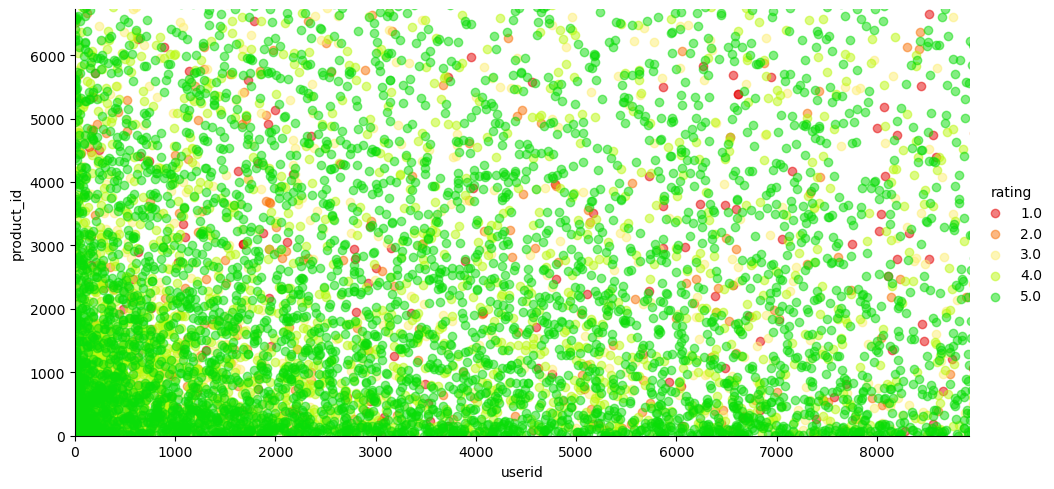

In [15]:
num_uniq_user = pdf['userid'].value_counts().count() 
num_uniq_item = pdf['product_id'].value_counts().count()

custompal = sns.xkcd_palette(['red', 'orange', 'sandy yellow', 'yellowgreen', 'vibrant green']) 

scplot = sns.lmplot(x = 'userid', y = 'product_id', data = pdf, 
                    hue = 'rating',
                    fit_reg = False,
                    aspect = 2, 
                    palette = custompal,
                    scatter_kws = {'alpha':0.5})
axes = scplot.axes
axes[0, 0].set_ylim(0, num_uniq_item)  
axes[0, 0].set_xlim(0, num_uniq_user) 

scplot

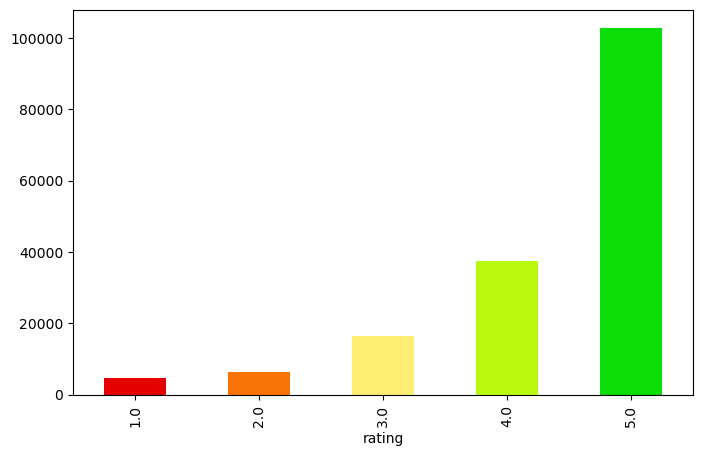

In [16]:
data_indexed.createOrReplaceTempView('df_ind') 

rating_count = spark.sql("""
      SELECT COUNT(rating) as count
      ,rating
      FROM df_ind
      GROUP BY rating""")

pandas_rc = rating_count.toPandas()  
pandas_rc.sort_values('rating',axis = 0, inplace = True)
pandas_rc.plot(x = 'rating', y = 'count', kind = 'bar', legend = False, color = custompal, figsize=(8,5))

plt.show()

<b>Note:</b> As we see with two charts that 5.0 rating products are high. So the dataset is good enough to pass into model.

## <a name="model">3. Building data</a>

### <a name="als">3.1 ALS</a>

In [17]:
# model
als = ALS(userCol = "userid", itemCol = "product_id", ratingCol = "rating",
          coldStartStrategy = 'drop', nonnegative = False)
     
# evaluator
rmseevaluator = RegressionEvaluator(metricName = "rmse", 
                                    labelCol = "rating", 
                                    predictionCol ="prediction")

# parameter grid
paramGrid = ParamGridBuilder()\
    .addGrid(als.rank, [1, 5, 10,50,70]) \
    .addGrid(als.maxIter, [15])\
    .addGrid(als.regParam, [0.05, 0.1, 0.5,5])\
    .build()

# train validation split
tvs = TrainValidationSplit(estimator = als,
                           estimatorParamMaps = paramGrid,
                           evaluator = rmseevaluator,
                           trainRatio = 0.8)

In [18]:
tvsmodel = tvs.fit(data_train)

In [28]:
import math
paramMap = list(zip(tvsmodel.validationMetrics, tvsmodel.getEstimatorParamMaps()))
paramMap = sorted(paramMap)
paramMap

[(1.1722677961926662,
  {Param(parent='ALS_65e8a1d4f31f', name='rank', doc='rank of the factorization'): 10,
   Param(parent='ALS_65e8a1d4f31f', name='maxIter', doc='max number of iterations (>= 0).'): 15,
   Param(parent='ALS_65e8a1d4f31f', name='regParam', doc='regularization parameter (>= 0).'): 0.5}),
 (1.1746566283762647,
  {Param(parent='ALS_65e8a1d4f31f', name='rank', doc='rank of the factorization'): 70,
   Param(parent='ALS_65e8a1d4f31f', name='maxIter', doc='max number of iterations (>= 0).'): 15,
   Param(parent='ALS_65e8a1d4f31f', name='regParam', doc='regularization parameter (>= 0).'): 0.5}),
 (1.1762704463671105,
  {Param(parent='ALS_65e8a1d4f31f', name='rank', doc='rank of the factorization'): 50,
   Param(parent='ALS_65e8a1d4f31f', name='maxIter', doc='max number of iterations (>= 0).'): 15,
   Param(parent='ALS_65e8a1d4f31f', name='regParam', doc='regularization parameter (>= 0).'): 0.5}),
 (1.1874436544470075,
  {Param(parent='ALS_65e8a1d4f31f', name='rank', doc='ran

As the list we will choose the 4 parameter because the first two seems go with the overfit

In [29]:
paramMap[3]

(1.1874436544470075,
 {Param(parent='ALS_65e8a1d4f31f', name='rank', doc='rank of the factorization'): 5,
  Param(parent='ALS_65e8a1d4f31f', name='maxIter', doc='max number of iterations (>= 0).'): 15,
  Param(parent='ALS_65e8a1d4f31f', name='regParam', doc='regularization parameter (>= 0).'): 0.5})

### <a name="evaluate">3.2 Evaluate</a>

In [30]:
als = ALS(userCol = "userid", itemCol = "product_id", ratingCol = "rating",
          coldStartStrategy = 'drop', nonnegative = False,
          rank = 5, maxIter = 15, regParam = 0.5)

In [33]:
model = als.fit(data_train)

In [35]:
predictions = model.transform(data_test)

In [37]:
predictions.select(["product_id", "userid", "rating", "prediction"]).show()

+----------+-------+------+----------+
|product_id| userid|rating|prediction|
+----------+-------+------+----------+
|     474.0| 6336.0|   1.0| 3.4715872|
|     518.0| 2142.0|   1.0| 3.1059291|
|    2636.0| 4101.0|   1.0| 2.7807367|
|    3706.0| 6620.0|   1.0| 3.8587286|
|    3973.0| 6397.0|   1.0|  3.832865|
|    6752.0| 2142.0|   1.0| 2.8196654|
|   10391.0| 4935.0|   1.0| 2.0827973|
|      72.0| 9376.0|   2.0| 4.0747323|
|     453.0| 3794.0|   2.0| 2.7073162|
|    1957.0| 6397.0|   2.0| 4.3896065|
|    2882.0| 6466.0|   2.0|  3.434759|
|    8345.0| 3175.0|   2.0|  2.231247|
|   11299.0|17753.0|   2.0| 3.0696297|
|      57.0| 2142.0|   3.0|  3.278453|
|     143.0| 6336.0|   3.0| 3.5004091|
|     144.0| 1238.0|   3.0| 3.9516492|
|     213.0|17420.0|   3.0|  4.399231|
|     339.0| 2659.0|   3.0|  4.152213|
|     472.0| 1580.0|   3.0| 3.5569427|
|     474.0| 2142.0|   3.0|  3.120437|
+----------+-------+------+----------+
only showing top 20 rows



In [38]:
rmse = rmseevaluator.evaluate(predictions)
print("Root-mean-square error = " + str(rmse))

Root-mean-square error = 1.1068385919551882


On average, this model is ~ 1.1 from perfect recommendations.

### <a name="predict">3.3 Prediction</a>

In [43]:
new_review_idx = userIndexed.filter((col("user") == "A3GJPLCZCDXXG6") |
                                    (col('user') == 'A34U85WY8ZWBPV') |
                                    (col('user') == 'A2VIY2TL6QPYLG')).select('user', 'userid', 'product_id')
new_review_idx.show()

+--------------+-------+----------+
|          user| userid|product_id|
+--------------+-------+----------+
|A3GJPLCZCDXXG6| 6190.0|    8034.0|
|A2VIY2TL6QPYLG| 7861.0|     138.0|
|A3GJPLCZCDXXG6| 6190.0|    6158.0|
|A3GJPLCZCDXXG6| 6190.0|    2753.0|
|A3GJPLCZCDXXG6| 6190.0|    5456.0|
|A3GJPLCZCDXXG6| 6190.0|    3940.0|
|A2VIY2TL6QPYLG| 7861.0|      46.0|
|A34U85WY8ZWBPV|16527.0|    3329.0|
|A2VIY2TL6QPYLG| 7861.0|     327.0|
|A2VIY2TL6QPYLG| 7861.0|    5699.0|
|A34U85WY8ZWBPV|16527.0|    9059.0|
|A34U85WY8ZWBPV|16527.0|    6597.0|
|A2VIY2TL6QPYLG| 7861.0|    6618.0|
|A34U85WY8ZWBPV|16527.0|   11477.0|
|A3GJPLCZCDXXG6| 6190.0|    3171.0|
|A34U85WY8ZWBPV|16527.0|    7861.0|
|A2VIY2TL6QPYLG| 7861.0|    2490.0|
|A2VIY2TL6QPYLG| 7861.0|     688.0|
|A3GJPLCZCDXXG6| 6190.0|       8.0|
|A3GJPLCZCDXXG6| 6190.0|    9593.0|
+--------------+-------+----------+



In [44]:
predictions = model.transform(new_review_idx)

In [45]:
predictions.show()

+--------------+-------+----------+----------+
|          user| userid|product_id|prediction|
+--------------+-------+----------+----------+
|A2VIY2TL6QPYLG| 7861.0|     138.0|  3.593776|
|A2VIY2TL6QPYLG| 7861.0|      46.0| 3.4224517|
|A2VIY2TL6QPYLG| 7861.0|     327.0|  3.280783|
|A2VIY2TL6QPYLG| 7861.0|    5699.0|  3.426787|
|A2VIY2TL6QPYLG| 7861.0|    6618.0| 3.6197624|
|A2VIY2TL6QPYLG| 7861.0|    2490.0|  3.831421|
|A2VIY2TL6QPYLG| 7861.0|     688.0| 3.4112628|
|A3GJPLCZCDXXG6| 6190.0|    8034.0|  4.599275|
|A3GJPLCZCDXXG6| 6190.0|    6158.0| 3.4588327|
|A3GJPLCZCDXXG6| 6190.0|    2753.0|  3.903339|
|A3GJPLCZCDXXG6| 6190.0|    5456.0|  4.546546|
|A3GJPLCZCDXXG6| 6190.0|    3940.0| 4.3579087|
|A34U85WY8ZWBPV|16527.0|    3329.0| 4.0655885|
|A34U85WY8ZWBPV|16527.0|    9059.0|   4.51187|
|A34U85WY8ZWBPV|16527.0|    6597.0| 4.4649453|
|A34U85WY8ZWBPV|16527.0|   11477.0|  4.729129|
|A3GJPLCZCDXXG6| 6190.0|    3171.0| 4.5209394|
|A34U85WY8ZWBPV|16527.0|    7861.0|  4.378086|
|A3GJPLCZCDXX

In [46]:
from pyspark.ml.feature import IndexToString

In [49]:
converter = IndexToString(inputCol = "product_id", outputCol = "Recommend product")
converted = converter.transform(predictions)
converted.select('user', 'Recommend product').show()

+--------------+-----------------+
|          user|Recommend product|
+--------------+-----------------+
|A2VIY2TL6QPYLG|       B00000JS5S|
|A2VIY2TL6QPYLG|       B0015AM26E|
|A2VIY2TL6QPYLG|       B003UNWV60|
|A2VIY2TL6QPYLG|       B0042FZOE6|
|A2VIY2TL6QPYLG|       B005KCDWAS|
|A2VIY2TL6QPYLG|       B009B7F6CA|
|A2VIY2TL6QPYLG|       B00A8UT58K|
|A3GJPLCZCDXXG6|       0615444172|
|A3GJPLCZCDXXG6|       B000ENW5Q0|
|A3GJPLCZCDXXG6|       B000EULX8E|
|A3GJPLCZCDXXG6|       B000IXMP6Q|
|A3GJPLCZCDXXG6|       B000NWX2W8|
|A34U85WY8ZWBPV|       B002Y29UIK|
|A34U85WY8ZWBPV|       B004Y3U90K|
|A34U85WY8ZWBPV|       B00516GB92|
|A34U85WY8ZWBPV|       B008DE0FU0|
|A3GJPLCZCDXXG6|       B0094J5G48|
|A34U85WY8ZWBPV|       B00955MRXO|
|A3GJPLCZCDXXG6|       B00DMC6KAC|
|A3GJPLCZCDXXG6|       B00GSN5H2O|
+--------------+-----------------+



In [ ]:
spark.catalog.clearCache()